In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sat Mar 30 15:02:02 2019

@author: bhunt
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings('ignore')
import gc
gc.enable()

Train_original = pd.read_csv('X_train.csv')
Train_y = pd.read_csv('y_train.csv')

In [ ]:

import scipy.fftpack

def Get_Fourier(df, Train_y):
    import math
    def Set_Up_Data(df):
        df=df.sort_values(by=['measurement_number'])
        return pd.DataFrame({
         'lin_a_x':[ df['linear_acceleration_X'].values ],
         'lin_a_y':[ df['linear_acceleration_Y'].values ],
         'lin_a_z':[ df['linear_acceleration_Z'].values ],
         'angular_x':[ df['angular_velocity_X'].values ],
         'angular_y':[ df['angular_velocity_Y'].values ],
         'angular_z':[ df['angular_velocity_Z'].values ],
        })
    
    df= df.groupby('series_id').apply(Set_Up_Data)
    
    def mfft(x):
        return [ x/math.sqrt(128.0) for x in np.absolute(np.fft.fft(x)) ][1:70] # Discrete Fourier Transform collecting 70 discrete components
    
    df['linx_f']=[ mfft(x) for x in df['lin_a_x'].values ]
    df['liny_f']=[ mfft(x) for x in df['lin_a_y'].values ]
    df['linz_f']=[ mfft(x) for x in df['lin_a_z'].values ]
    df['angx_f']=[ mfft(x) for x in df['angular_x'].values ]
    df['angy_f']=[ mfft(x) for x in df['angular_y'].values ]
    df['angz_f']=[ mfft(x) for x in df['angular_z'].values ]

    
    df=pd.merge(df,Train_y[['series_id','surface','group_id']],on='series_id')
    df=df.rename(columns={"surface": "y"})
    
    def aggfourier(df, feature):
        va= np.array(df[feature].tolist())
        mean= sum(va)/va.shape[0]
        var= sum([ (va[i,:]-mean)**2 for i in range(va.shape[0]) ])/va.shape[0]
        dev= [ math.sqrt(x) for x in var ]
        return pd.DataFrame({
                'mean': [ mean ],
                'dev' : [ dev ],
                })
    
    plt.figure(figsize=(16, 8*8))

    features=['linx_f','liny_f','linz_f','angx_f','angy_f','angz_f']
    
    display={
            'hard_tiles_large_space':'r-.',
            'concrete':'g-.',
            'tiled':'b-.',

            'fine_concrete':'r-',
            'wood':'g-',
            'carpet':'b-',
            'soft_pvc':'y-',
            
            'hard_tiles':'r--',
            'soft_tiles':'g--',
            }

    count=0

    for feature in features:
        plt.figure(figsize=(16, 8*8))
        stat= df.groupby('y').apply(aggfourier,feature)
        stat.index= stat.index.droplevel(-1)
        b=[*range(len(stat.at['carpet','mean']))]

        count+=1
        plt.subplot(len(features)+1,1,count)
        for i,(k,v) in enumerate(display.items()):
            plt.plot(b, stat.at[k,'mean'], v, label=k)
            # plt.errorbar(b, stat.at[k,'mean'], yerr=stat.at[k,'dev'], fmt=v)
   
        leg = plt.legend(loc='best', ncol=3, mode="expand", shadow=True, fancybox=True)
        plt.title("sensor: " + feature)
        plt.xlabel("frequency component")
        plt.ylabel("amplitude")
        plt.show()



<Figure size 1152x4608 with 0 Axes>

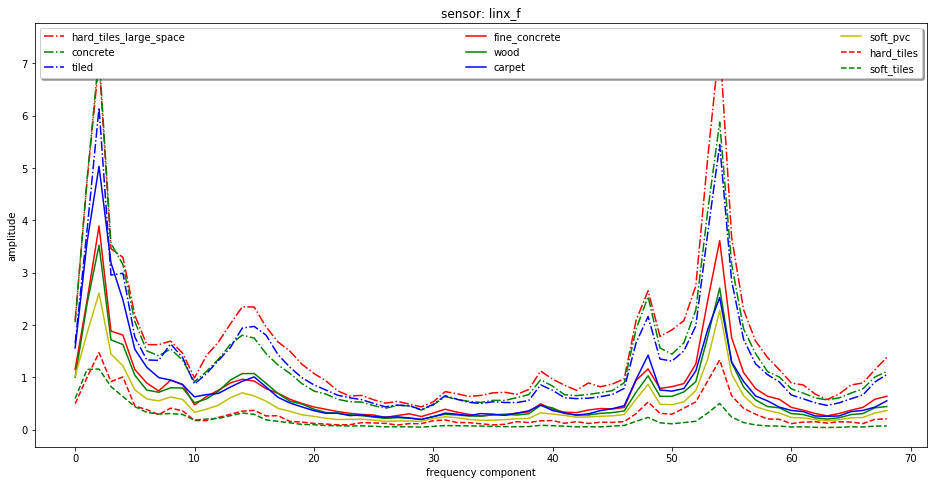

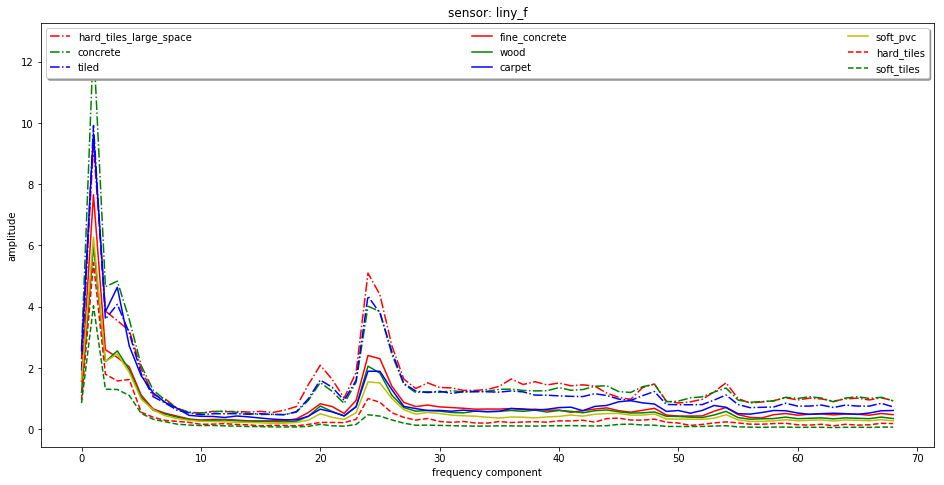

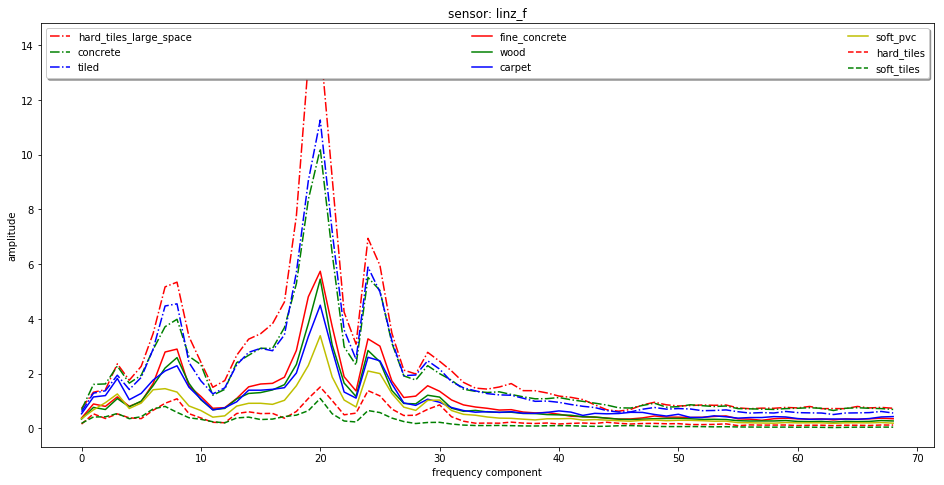

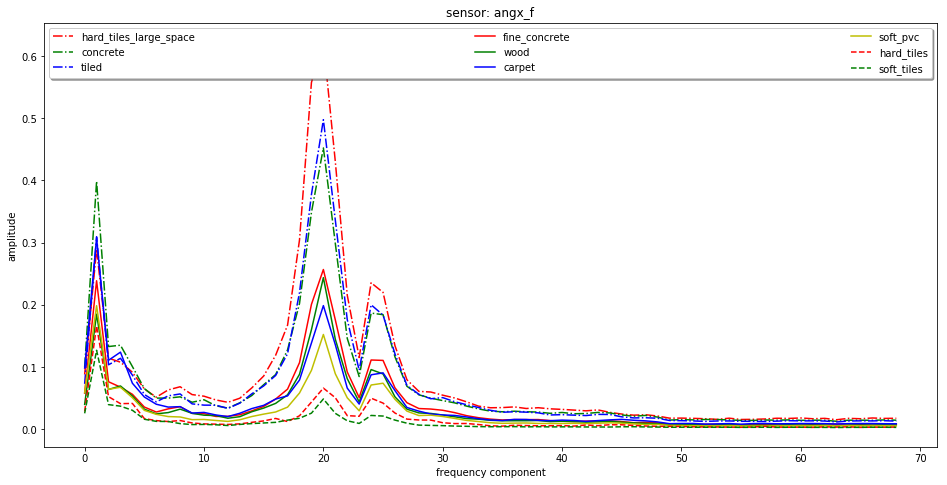

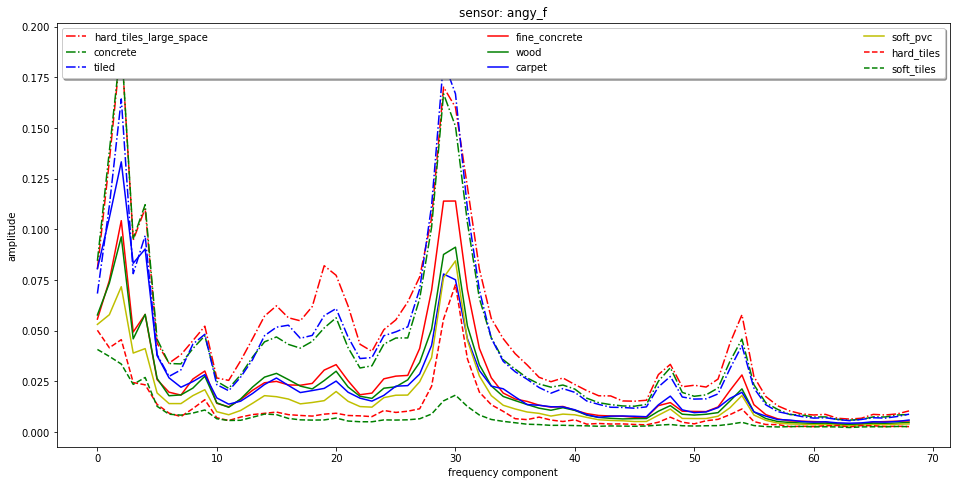

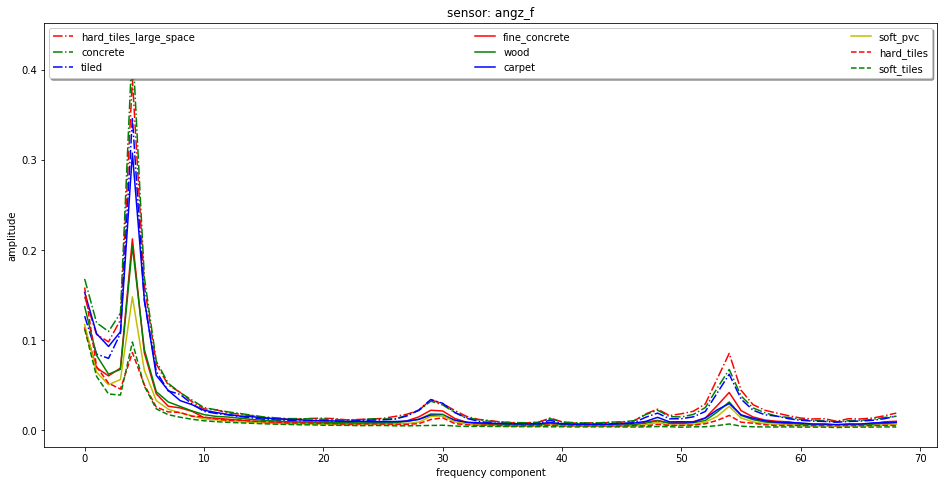

In [4]:
Get_Fourier(Train_original, Train_y)

In [ ]:
testset = pd.read_csv('X_test_extraction2.csv')

dataset = pd.read_csv('X_train_newfeat2.csv')

#%%

testsetextra = pd.read_csv('X_test_extravarsextraction_step1.csv')

datasetextra = pd.read_csv('X_train_extra_vars_newfeat2.csv')



#%%
y = pd.read_csv('C:/Users/bhunt\OneDrive/Documents/KaggleData/Robot Career Competition/career-con-2019/y_train.csv')
y = y.drop(["series_id", "group_id"], axis=1)
labels = LabelEncoder()
labels.fit(list(y.values))
y = labels.transform(list(y.values))
#y = pd.DataFrame(np.array(y).reshape(len(y), 1))
y = pd.Series(np.array(y).reshape(len(y)))



#%%

testset = pd.concat([testset, testsetextra], axis=1, sort=False)

dataset = pd.concat([dataset, datasetextra], axis=1, sort=False)

testset = testset.loc[:,~testset.columns.duplicated()]
dataset = dataset.loc[:,~dataset.columns.duplicated()]
#%%

excesscols = []

for col in testset:
    if(col not in dataset):
        #testset = testset.drop(col, axis = 1)
        excesscols.append(col)
#%%
        
testset = testset.drop(excesscols, axis = 1 )


#%%
#testset = testset[dataset.columns]
print(testset.shape)
print(dataset.shape)
print(testset.columns == dataset.columns)

all_data = pd.concat([dataset, testset])



dataset = all_data[:len(dataset)]

testset = all_data[len(dataset):]

#%%
folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=59)
predicted = np.zeros((testset.shape[0],9))
measured= np.zeros((dataset.shape[0]))
score = 0

indices = []

for times, (trn_idx, val_idx) in enumerate(folds.split(dataset.values,y.values)):
    model = RandomForestClassifier(n_estimators=500, n_jobs = -1)
    #model = RandomForestClassifier(n_estimators=1000, max_depth=10, min_samples_split=3, n_jobs=-1)
    model.fit(dataset.iloc[trn_idx],y.iloc[trn_idx])
    measured[val_idx] = model.predict(dataset.iloc[val_idx])
    predicted += model.predict_proba(testset)/folds.n_splits
    score += model.score(dataset.iloc[val_idx],y.iloc[val_idx])
    print("Fold: {} score: {}".format(times,model.score(dataset.iloc[val_idx],y.iloc[val_idx])))

    importances = model.feature_importances_
    indices.append(np.argsort(importances))
    features = dataset.columns
    
    
    gc.collect()

#%%
    
savedscore = score
df = pd.DataFrame(indices)
ratings = df.median()
dropable = [x for x in range(len(ratings)) if ratings[x] > 4000]
#%%
getridof = [dataset.columns[x] for x in range(len(dropable))]
dataset = dataset.drop(columns = getridof)
testset = testset.drop(columns = getridof)
#%%
test_predict = pd.Series(model.predict(testset))
test_predict = test_predict.astype(int)
test_predictwords = labels.inverse_transform(list(test_predict.values))
test_predictionsfinal = pd.DataFrame(data=test_predictwords,  columns=["surface"])
all_ids = list(range(len(test_predict)))
test_predictionsfinal["series_id"] = all_ids
cols_pred = test_predictionsfinal.columns.tolist()
cols_pred = cols_pred[-1:] + cols_pred[:-1]
test_predictionsfinal = test_predictionsfinal[cols_pred]
test_predictionsfinal.to_csv(path_or_buf='predictionrandforest.csv')